## Models Notebook
This notebook holds the FSM with iterations and different models as well as evaluation. I chose to use Sci-Kit Learn's Dummy Classifier as baseline and improve from there. This FSM was trained on a dataset containing athletes from the Summer Olympics from 2012(London) and 2016(Rio). This dataset was obtained from Kaggle and I ran into issues with the puctuation and spelling of athlete names. For the next model iterations I chose to scrape a new dataset from Olympedia which provides the same spelling and puctuation for athlete names, producing more matches when merging event results.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Loading in libraries for data preprocessing, modeling, and evaluation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from Olympic_PED_use.src import functions as fn

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier


In [3]:
df = pd.read_csv('../data/model_df.csv')

Defining the columns that were merged to the dataframe containing results for each individual event. I am going to sum the results for each athlete and add them to a result column containing the total. I need to start by filling the missing values with 0 so they aren't included in the sum of results.

In [18]:
df.columns[15:56]

Index(['result_100m_mens_london', 'result_100m_womens_rio',
       'result_100m_womens_london', 'result_200m_mens_rio',
       'result_200m_mens_london', 'result_200m_womens_rio',
       'result_200m_womens_london', 'result_110h_mens_rio',
       'result_110h_mens_london', 'result_100h_womens_rio',
       'result_100h_womens_london', 'result_3000steep_mens_rio',
       'result_3000steep_mens_london', 'result_3000steep_womens_rio',
       'result_3000steep_womens_london', 'result_marathon_mens_rio',
       'result_marathon_mens_london', 'result_marathon_womens_rio',
       'result_marathon_womens_london', 'result_20km_mens_rio',
       'result_20km_mens_london', 'result_20km_womens_rio',
       'result_20km_womens_london', 'result_400m_mens_rio',
       'result_400m_mens_london', 'result_400m_womens_rio',
       'result_400m_womens_london', 'result_5000m_mens_rio',
       'result_5000m_mens_london', 'result_5000m_womens_rio',
       'result_5000m_womens_london', 'result_800m_mens_rio',


In [4]:
result_cols = df.columns[15:56]

In [5]:
for x in df[result_cols]:
    df[x] = df[x].fillna(value=0.0)

### Final Preprocessing
- Filling in the flagged column's missing values with 0 (no positive PED use)
- Inserting a column 'ped_use' to merge the summed results on
- Defining result columns that were merged to the dataframe so I can get the sum
- Subsetting the dataframe to only the event result columns and inserting a 'ped_use' column 
- Filling the missing values in the height and weight features by adding the before and after values and dividing by 2

In [6]:
df.flagged = df.flagged.fillna(value=0)
df = df.drop(['id'], axis=1)
df.insert(56, 'ped_use', 0)
cols = df.columns[15:56]
results = df[result_cols]
results.insert(41, 'ped_use', 0)
results.ped_use = results[list(results.columns)].sum(axis=1)
df.ped_use = results.ped_use
df.rename(columns={'ped_use':'results'}, inplace=True)
df = df.drop(['substance', 'event_y'], axis=1)
df.height = (df.height.fillna(method='ffill') + df.height.fillna(method='bfill')/2)
df.weight = (df.weight.fillna(method='ffill') + df.weight.fillna(method='bfill')/2)
medal_numeric = {np.nan: 0,
                 'Bronze': 1,
                 'Silver': 2,
                 'Gold': 3}
df['medal'] = df.medal.replace(medal_numeric)

/opt/anaconda3/envs/olympic-env/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#### Performing train test split on data for model evaluation

In [7]:
X = df.drop('flagged', axis=1)
y = df.flagged
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.2)

#### Defining the continuous and categorical features in the data for Scaling and One Hot Encoding

In [8]:
cont_features = ['age', 'height', 'weight', 'results']
cat_features = ['sex', 'team', 'noc', 'season', 'city', 'sport',
                       'event_x', 'medal']

In [9]:
df.team.value_counts()

United States    350
Great Britain    213
Germany          179
Jamaica          172
Ukraine          153
                ... 
Monaco             2
San Marino         2
Iraq               2
Luxembourg         2
Liechtenstein      1
Name: team, Length: 205, dtype: int64

#### Checking the correlation of the features to make sure they aren't highly correlated

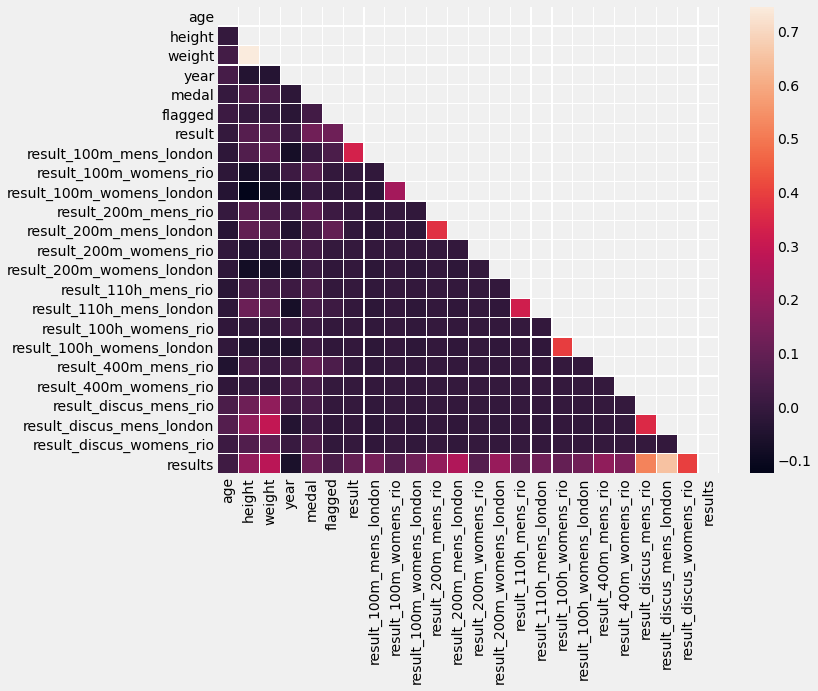

In [258]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(df.corr(),linewidths=.2, mask=mask);

#### Scaling and encoding features and creating dataframes for each

In [10]:
X_train_cont = X_train[cont_features].astype(float)
X_train_cat = X_train[cat_features]
X_test_cont = X_test[cont_features].astype(float)
X_test_cat = X_test[cat_features]

X_train_index = X_train.index
X_test_index = X_test.index

ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_cont), 
                              columns=X_train[cont_features].columns, 
                              index=X_train_index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_cont), 
                             columns=X_test[cont_features].columns, 
                             index=X_test_index)
ohe = OneHotEncoder(drop='first')
X_train_encoded = ohe.fit_transform(X_train_cat)
X_test_encoded = ohe.transform(X_test_cat)

train_columns = ohe.get_feature_names(input_features=X_train_cat.columns)
test_columns = ohe.get_feature_names(input_features=X_test_cat.columns)

X_train_processed = pd.DataFrame(X_train_encoded.todense(), columns=train_columns, index=X_train_index)
X_test_processed = pd.DataFrame(X_test_encoded.todense(), columns=test_columns, index=X_test_index)

#### Concatenating the scaled and encoded to begin modeling.

In [11]:
X_train_all = pd.concat([X_train_scaled, X_train_processed], axis=1)
X_test_all = pd.concat([X_test_scaled, X_test_processed], axis=1)

#### Instantiating Dummy Classifier as a baseline model. Evaluating the performance by the mean cross_val_score over 5 splits 
#### I have chosen to optimize for recall score, limiting the amount of false negatives. The model classifying a clean athlete in the positive PED class wouldn't be as bad as the model classifying a doping athlete in the negative PED class. When the model flags a clean athlete, their sample can be retested and the results would prove they are clean. If the model classifys a doping athlete as a clean athlete, their sample may not get selected for re-testing. 

0.05
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1031
         1.0       0.00      0.00      0.00        17

    accuracy                           0.97      1048
   macro avg       0.49      0.49      0.49      1048
weighted avg       0.97      0.97      0.97      1048

Recall:  0.0
Accuracy:  0.9675572519083969
Precision:  0.0


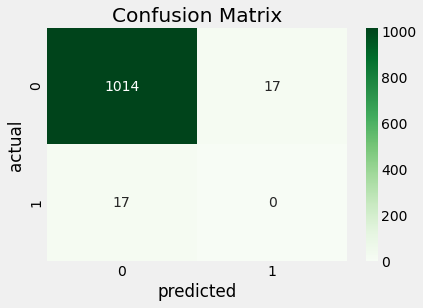

In [171]:
fsm = DummyClassifier(random_state=42)
fsm.fit(X_train_all, y_train)
print(np.mean(cross_val_score(fsm, X_test_all, y_test, scoring='recall',
                             cv=5, n_jobs=-1)))
fn.evaluation(y_test, fsm.predict(X_test_all))

This baseline model is not successfully classifying any PED use. This is more than likely cause by the significant class imbalance issue. I will try SMOTE resampling on the next iteration. The recall cross_val_score was around 5 percent, next I will check the ROC-AUC

In [172]:
df.flagged.value_counts()
pivot_flagged = df.pivot_table(index='flagged', values='results', aggfunc='count')
pivot_flagged

,results
flagged,
0.0,5156
1.0,84


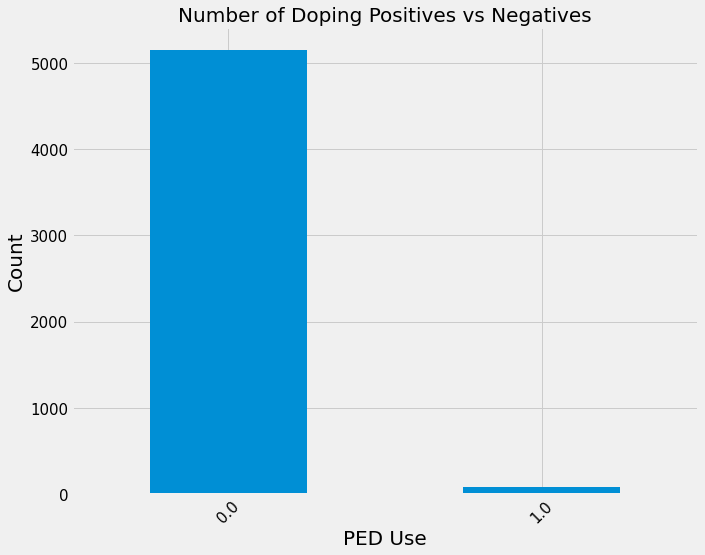

In [173]:
plt.style.use('fivethirtyeight')
plt.figure.figsize=(10,8)
pivot_flagged.plot(kind='bar', figsize=(10,8), fontsize=15, rot=45)
plt.xlabel('PED Use', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Number of Doping Positives vs Negatives', fontsize=20)
plt.legend().remove()

#### This level of class imbalance is significantly high, since I currently only have results from 2012 and 2016, the model does not have enough of the positive class to train on.

In [154]:
fsm_preds = fsm.predict(X_test_all)
fpr, tpr, thresholds = roc_curve(y_test, fsm_preds)
rocauc = auc(fpr, tpr)

In [155]:
rocauc

0.4917555771096023

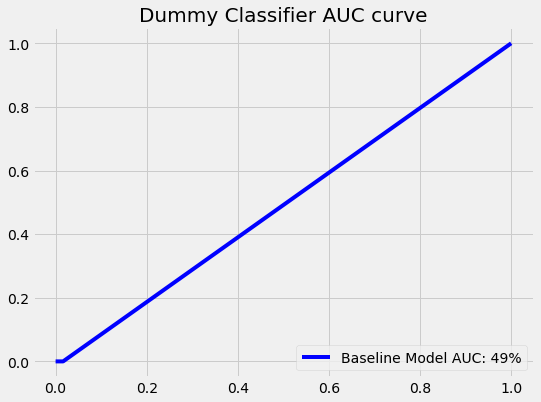

In [204]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))    
plt.plot(fpr, tpr, c='b', label='Baseline Model AUC: 49%')
plt.title('Dummy Classifier AUC curve', fontsize=20)
plt.legend(loc='lower right')
#plt.savefig('fsm_auc.png', bbox_inches='tight', transparent=True)

#### The plot above shows an Area Under the Curve (AUC) of 49%, indicating it is not performing well at distinguising the positive from the negative class, positive or negative PED use in our case.
## 

#### I am going to try oversampling the minority class with SMOTE and use Sci-Kit Learn's Random Forest Classifier

In [178]:
# I need to remove the target label so it isn't encoded with the categorical features
train = df.drop('flagged', axis=1)

#### Performing the same preprocessing steps as above except on all of the data before the train test split

In [179]:
train_ohe = train[cat_features]
train_cont = train[cont_features]
train_index = train.index

ohe2 = OneHotEncoder(drop='first')
ss2 = StandardScaler()

train_encoded = ohe2.fit_transform(train_ohe)
train_scaled = pd.DataFrame(ss2.fit_transform(train_cont), columns=train[cont_features].columns, index=train_index)

train_columns = ohe2.get_feature_names(input_features=train_ohe.columns)
train_processed = pd.DataFrame(train_encoded.todense(), columns = train_columns, index=train_index)

train_all = pd.concat([train_scaled, train_processed], axis=1)

In [180]:
train_all['flagged'] = df['flagged']

#### Defining x and y for SMOTE resampling

In [181]:
X_smote = train_all.drop('flagged', axis=1)
y_smote = train_all.flagged

smote = SMOTE(random_state=42)

x_res, y_res = smote.fit_sample(X_smote, y_smote)

#### Performing train test split on the resampled data

In [182]:
X_t, X_val, y_t, y_val = train_test_split(x_res, y_res, random_state=42, test_size=.2)

#### Instantiating a Random Forest Classifier with
- max_depth: 60
- min_samples_split: 2
- n_estimators: 1000

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


0.1


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1041
         1.0       1.00      1.00      1.00      1022

    accuracy                           1.00      2063
   macro avg       1.00      1.00      1.00      2063
weighted avg       1.00      1.00      1.00      2063

Recall:  0.9990215264187867
Accuracy:  0.9995152690256908
Precision:  1.0


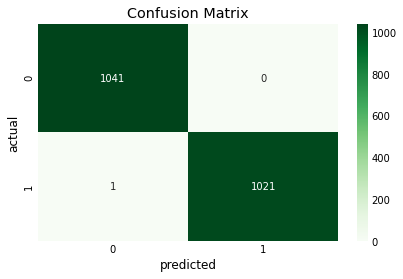

In [187]:
rf2 = RandomForestClassifier(max_depth=60, min_samples_split=2, 
                             n_estimators=1000, n_jobs=-1, 
                             verbose=1, random_state=42)
rf2.fit(X_t, y_t)

print(np.mean(cross_val_score(rf2, X_test_all, y_test, scoring='recall',
                       n_jobs= -1, verbose=1, cv=5)))

fn.evaluation(y_val, rf2.predict(X_val))

#### Fitting the random forest classifier trained on the resampled data to the original X_train and y_train. Evaluating the performance on the testing data

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1031
         1.0       1.00      0.47      0.64        17

    accuracy                           0.99      1048
   macro avg       1.00      0.74      0.82      1048
weighted avg       0.99      0.99      0.99      1048

Recall:  0.47058823529411764
Accuracy:  0.9914122137404581
Precision:  1.0


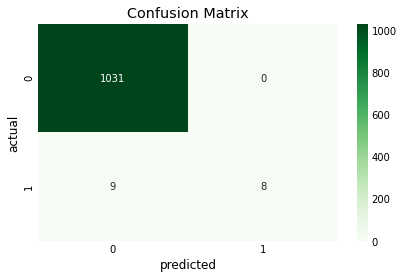

In [191]:
rf2.fit(X_train_all, y_train)
preds = rf2.predict(X_test_all)
fn.evaluation(y_test, preds)

In [201]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf2.predict(X_test_all))
rf_rocauc = auc(rf_fpr, rf_tpr)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


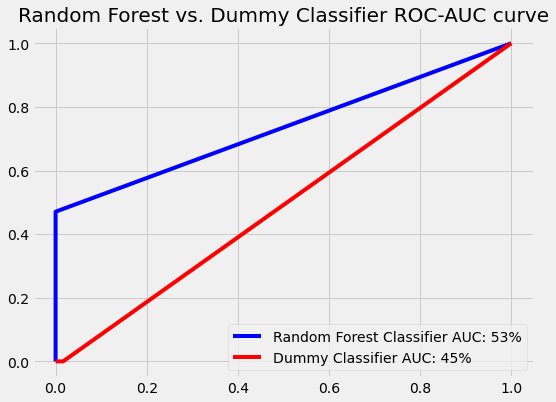

In [202]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))    
plt.plot(rf_fpr, rf_tpr, c='b', label='Random Forest Classifier AUC: 53%')
plt.plot(fpr, tpr, c='r', label='Dummy Classifier AUC: 45%')
plt.title('Random Forest vs. Dummy Classifier ROC-AUC curve', fontsize=20)
plt.legend(loc='lower right')
plt.savefig('auc.png', bbox_inches='tight', transparent=True)

#### The AUC has improved from the baseline model from 49% to 74%, indicating that the SMOTE resampling improved the model's ability in distinguishing the classes.
#### The recall score also has improved from 0% to 47% meaning the model was able to catch more PED users

In [203]:
auc(rf_fpr, rf_tpr)

0.7352941176470589

In [234]:
print(np.mean(cross_val_score(rf2, X_train_all, y_train, scoring='recall', 
                       cv=3, n_jobs= -1, verbose=1)))

print(np.mean(cross_val_score(rf2, X_test_all, y_test, scoring='recall', 
                       cv=3, n_jobs= -1, verbose=1)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


0.40513833992094866
0.12222222222222223


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


#### The results from the cross validation score show that the model is overfit. 

<AxesSubplot:>

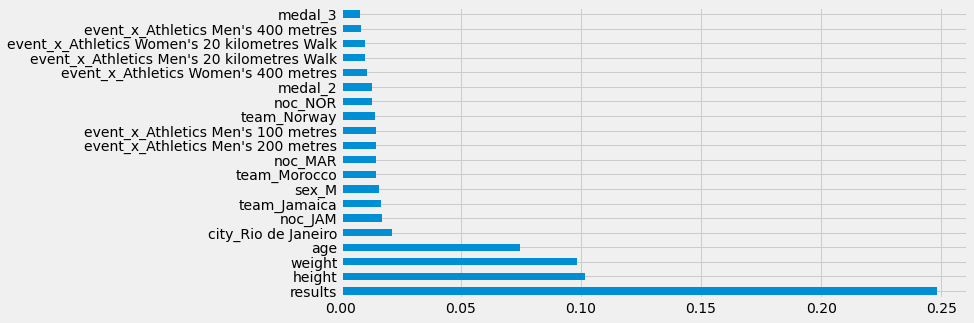

In [233]:
plt.style.use('fivethirtyeight')
feat_importances = pd.Series(rf2.feature_importances_, index=X_train_all.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=(10,5))

#### The plot above shows the top 20 features of importance for the Random Forest Classifier. The results feature as well as the age, weight, and height features have the highest importance.

## Decision Tree Classifier

The cell below loops through different max_depths from 1-50 and plots the auc curve of all depths. It looks like I should keep the max depth between 5 and 10

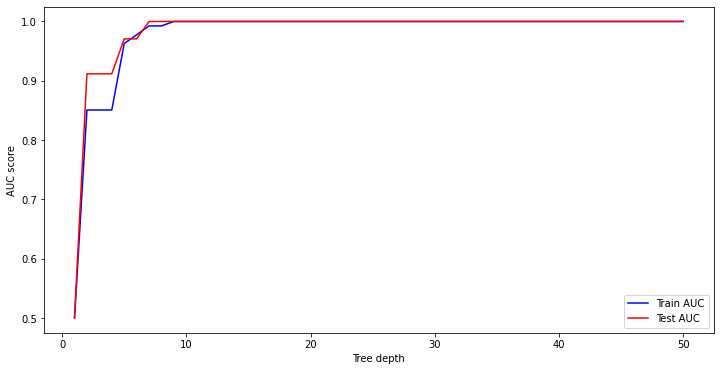

In [12]:
max_depths = np.linspace(1, 50, 50, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    dt.fit(X_train_all, y_train)
    train_pred = dt.predict(X_train_all)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    train_results.append(roc_auc)
    y_pred = dt.predict(X_test_all)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

The cell below loops through different min_samples_splits from 0.1 to 1, the plot shows that the auc decreases significantly at a min_samples_splits of .2

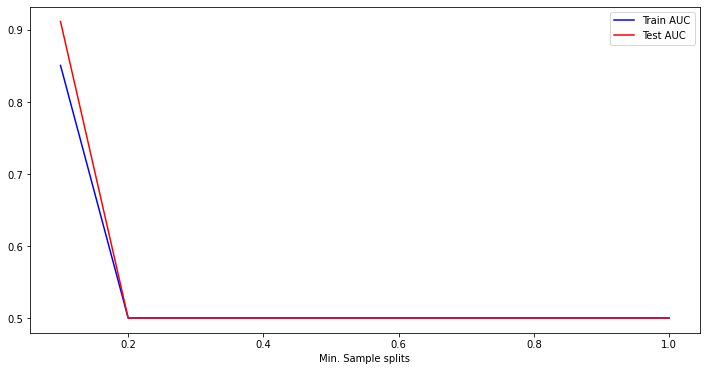

In [13]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=42)
    dt.fit(X_train_all, y_train)
    train_pred = dt.predict(X_train_all)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test_all)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1031
         1.0       1.00      0.82      0.90        17

    accuracy                           1.00      1048
   macro avg       1.00      0.91      0.95      1048
weighted avg       1.00      1.00      1.00      1048

Recall:  0.8235294117647058
Accuracy:  0.9971374045801527
Precision:  1.0


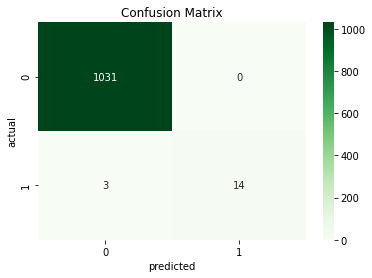

<function mean at 0x7f94f8067200>


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


0.8222222222222223


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


In [14]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=7,
                            min_samples_split=.13, random_state=42)
dt.fit(X_train_all, y_train)
preds = dt.predict(X_test_all)
fn.evaluation(y_test, preds)
print(np.mean)

print(np.mean(cross_val_score(dt, X_test_all, y_test, scoring='recall', 
                       cv=3, n_jobs= -1, verbose=1)))

This is the best model iteration so far, it is a great improvement from the baseline model. I will stick with these results and begin feature engineering for the next model iterations.

In [15]:
from sklearn.tree import plot_tree

[Text(111.60000000000001, 190.26, 'results <= -0.244\nentropy = 0.118\nsamples = 4192\nvalue = [4125, 67]'),
 Text(55.800000000000004, 135.9, 'entropy = 0.0\nsamples = 3586\nvalue = [3586, 0]'),
 Text(167.4, 135.9, 'results <= 0.199\nentropy = 0.502\nsamples = 606\nvalue = [539, 67]'),
 Text(111.60000000000001, 81.53999999999999, 'entropy = 0.0\nsamples = 47\nvalue = [0, 47]'),
 Text(223.20000000000002, 81.53999999999999, 'noc_JAM <= 0.5\nentropy = 0.223\nsamples = 559\nvalue = [539, 20]'),
 Text(167.4, 27.180000000000007, 'entropy = 0.119\nsamples = 499\nvalue = [491, 8]'),
 Text(279.0, 27.180000000000007, 'entropy = 0.722\nsamples = 60\nvalue = [48, 12]')]

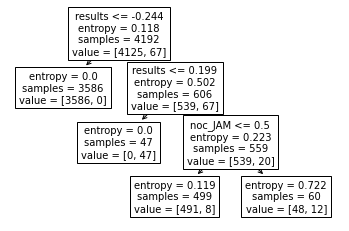

In [17]:
plot_tree(dt, feature_names=X_train_all.columns)